# Exogenous Causal Forest

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 20000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 0.0 * X[:, [0]] + np.random.normal(0, 1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [3]:
from econml.grf import CausalForest
est = CausalForest(criterion='het', n_estimators=4000, min_samples_leaf=5, max_depth=None,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=1, n_jobs=-1, random_state=1235)

In [4]:
%time est.fit(X, T, y.reshape(-1, 1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.4min


Wall time: 2min


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.9min finished


CausalForest(criterion='het', n_estimators=4000, n_jobs=-1, random_state=1235,
             verbose=1)

In [5]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01, var_correction=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.3s


Wall time: 3.39 s


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.6s finished


In [6]:
%time point = est.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s


Wall time: 993 ms


[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.8s finished


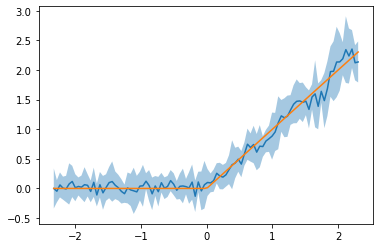

In [7]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

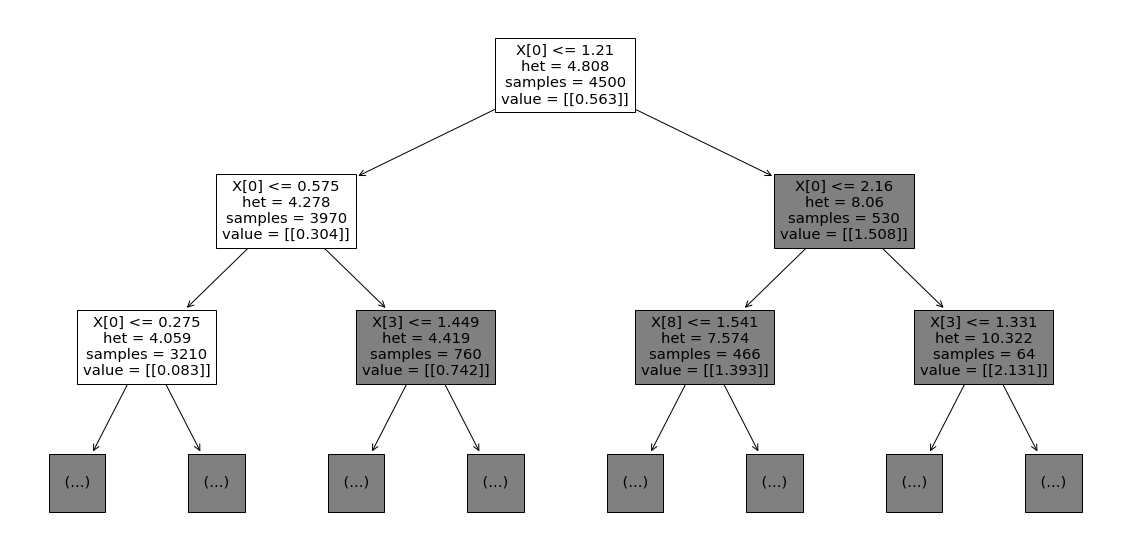

In [8]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[1], impurity=True, max_depth=2)
plt.show()

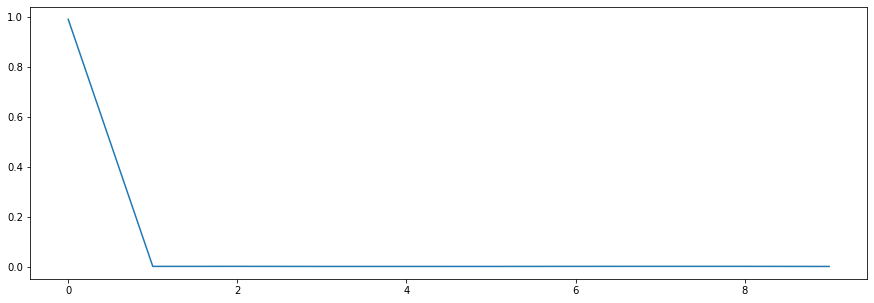

In [9]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [10]:
est.decision_path(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    1.5s finished


(<1x4788300 sparse matrix of type '<class 'numpy.int64'>'
 	with 55569 stored elements in Compressed Sparse Row format>,
 array([      0,    1189,    2374, ..., 4785916, 4787123, 4788300],
       dtype=int32))

In [11]:
est.apply(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    0.3s finished


array([[427, 595, 372, ...,  53, 717, 345]], dtype=int64)

### Running time comparison with a simple regression forest predicting the treatments

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=4000, min_samples_leaf=40, max_samples=.45, n_jobs=-1, max_depth=None, verbose=0)

In [ ]:
%time rf.fit(X, np.hstack([T, T[:, [0]]]))
%time pred = rf.predict(X)

### Comparison with ForestDML

In [14]:
from econml.dml import ForestDML
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
est = ForestDML(model_y=RandomForestRegressor(min_samples_leaf=100),
                model_t=RandomForestRegressor(min_samples_leaf=100),
                n_estimators=4000, min_samples_leaf=20, subsample_fr=.9,
                max_depth=100, verbose=0, n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
%time est.fit(y, T, X=X)

In [ ]:
%time point = est.effect(X_test)

In [ ]:
%time lb, ub = est.effect_interval(X_test, alpha=0.01)

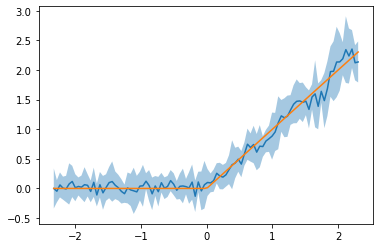

In [18]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

# IV Causal Forest

In [ ]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 5000
n_features = 10
n_treatments = 2
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [ ]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=4000, min_samples_leaf=20,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [ ]:
%time est.fit(X, T, y, Z=Z)

In [ ]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

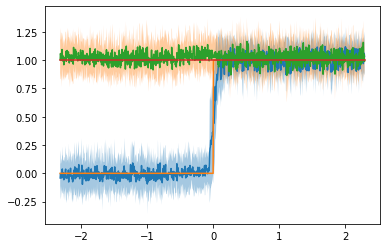

In [23]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

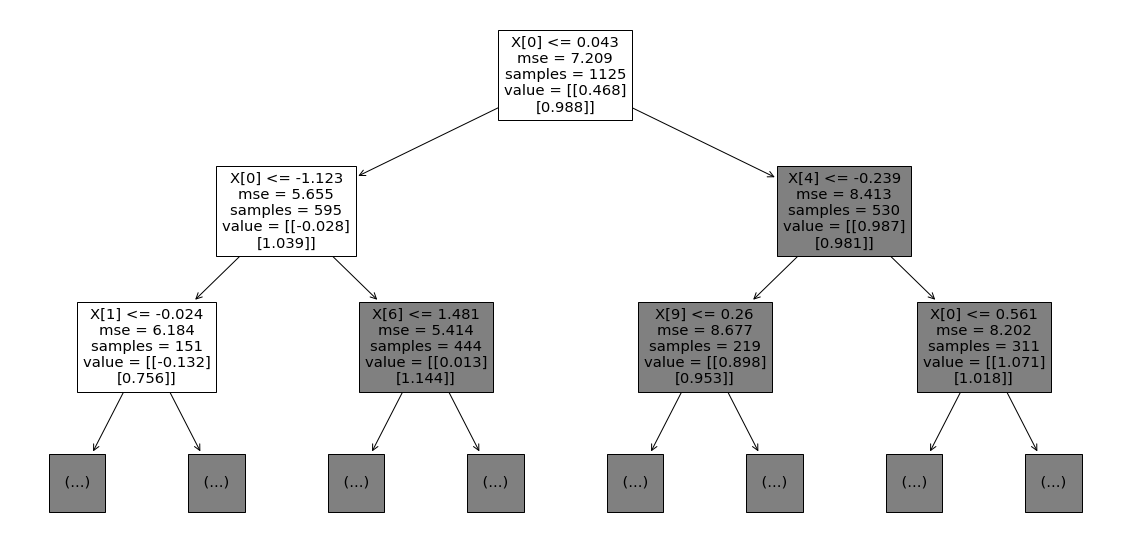

In [24]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

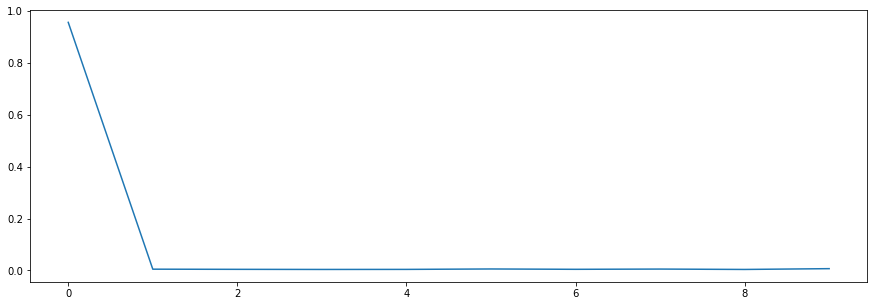

In [25]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [26]:
est[0].decision_path(X_test[:1])

<1x77 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [27]:
est[0].apply(X_test[:1])

array([4], dtype=int64)

# Regression Forest

In [28]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 2000
n_features = 10
n_outputs = 2
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_outputs - 1))*np.arange(1, n_outputs).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [30]:
from econml.grf import RegressionForest
est = RegressionForest(n_estimators=4000, min_samples_leaf=5, max_depth=None,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, subforest_size=4,
                   honest=True, verbose=1, n_jobs=-1, random_state=1235)

In [31]:
%time est.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    4.2s


Wall time: 7.29 s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    5.3s finished


RegressionForest(n_estimators=4000, n_jobs=-1, random_state=1235, verbose=1)

In [32]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01, var_correction=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s


Wall time: 2.25 s


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.2s finished


In [33]:
%time point = est.predict(X_test, interval=False, alpha=0.01, var_correction=True)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s


Wall time: 1.02 s


[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.9s finished


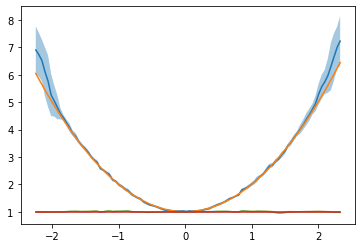

In [34]:
import matplotlib.pyplot as plt
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

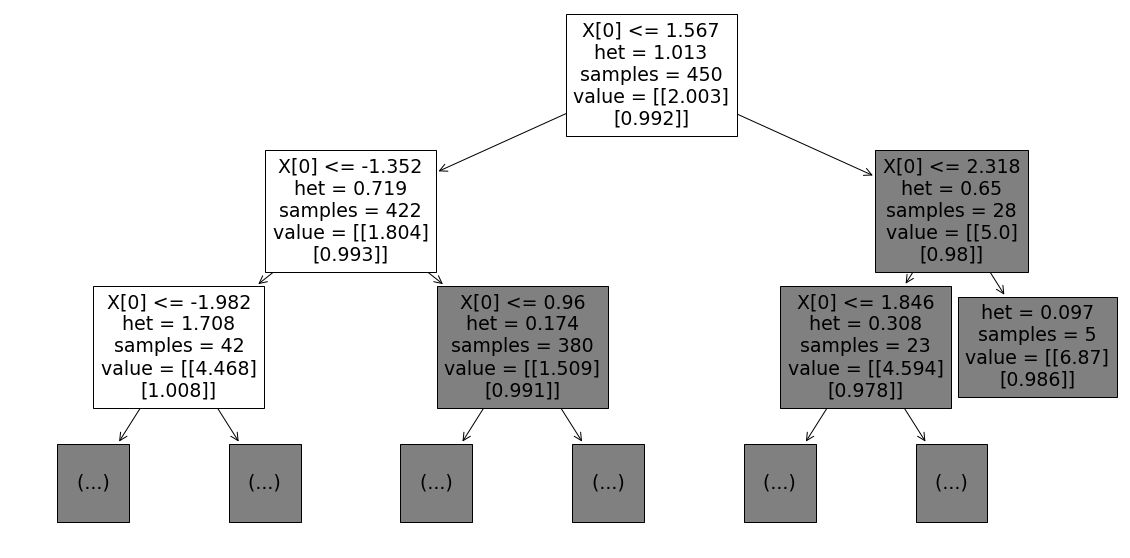

In [35]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

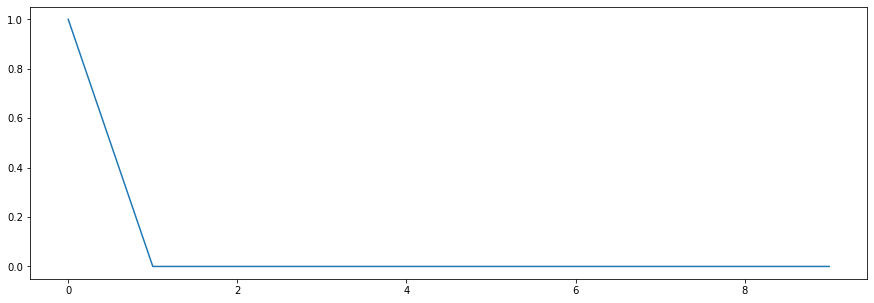

In [36]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

# Combining with DML

In [2]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
# T[:, 1] = .9 * T[:, 0] + .1 * T[:, 1]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [4]:
from econml.dml import CausalForestDML
est = CausalForestDML(criterion='mse', n_estimators=4000, 
                      verbose=1, discrete_treatment=False,
                      n_jobs=-1, random_state=123).fit(y.ravel(), T, X, W)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: 

In [5]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 1000 

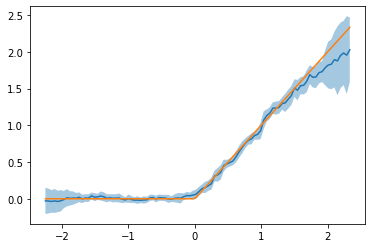

In [6]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    plt.fill_between(X_test[:,0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

In [7]:
res.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,-0.028,0.069,-0.407,0.684,-0.142,0.086
1,-0.031,0.066,-0.472,0.637,-0.139,0.077
2,-0.036,0.060,-0.595,0.552,-0.135,0.063
3,-0.029,0.063,-0.469,0.639,-0.133,0.074
4,-0.037,0.057,-0.645,0.519,-0.130,0.057
...,...,...,...,...,...,...
95,1.876,0.182,10.316,0.000,1.577,2.175
96,1.951,0.174,11.244,0.000,1.666,2.236
97,1.983,0.170,11.692,0.000,1.704,2.262
98,1.954,0.205,9.512,0.000,1.616,2.292


In [8]:
res = est.effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1000 

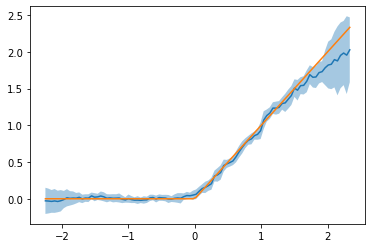

In [9]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point)
    plt.fill_between(X_test[:,0], lb, ub, alpha=.4)
    plt.plot(X_test[:, 0], np.sum(true_te(X_test), axis=1))
plt.show()

In [10]:
res.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
0,-0.028,0.069,-0.407,0.684,-0.142,0.086
1,-0.031,0.066,-0.472,0.637,-0.139,0.077
2,-0.036,0.060,-0.595,0.552,-0.135,0.063
3,-0.029,0.063,-0.469,0.639,-0.133,0.074
4,-0.037,0.057,-0.645,0.519,-0.130,0.057
...,...,...,...,...,...,...
95,1.876,0.182,10.316,0.000,1.577,2.175
96,1.951,0.174,11.244,0.000,1.666,2.236
97,1.983,0.170,11.692,0.000,1.704,2.262
98,1.954,0.205,9.512,0.000,1.616,2.292


#### Comparison with OrthoForest

In [ ]:
from econml.ortho_forest import DMLOrthoForest
est = DMLOrthoForest().fit(y, T, X, W)

In [4]:
point = est.const_marginal_effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.1s finished


In [7]:
lb, ub = est.const_marginal_effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished


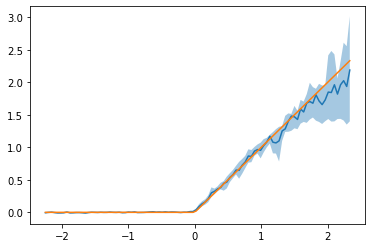

In [9]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, 0, 0])
    plt.fill_between(X_test[:,0], lb[:, 0, 0], ub[:, 0, 0], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()